# YOUTUBE API FOR PYTHON



Bryan Hurtado

In this project I Analyzing video data of data science channels using Youtube API for Python

In [1]:
!pip install isodate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [3]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Data creation with Youtube API

In [4]:
api_key = ''

channel_ids = ['UCtYLUTtgS3k1Fg4y5tAhLbw', # Statquest
               'UCCezIgC97PvUuR4_gbFUs5g', # Corey Schafer
               'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
               'UCNU_lfiiWBdtULKOw6X0Dig', # Krish Naik
               'UCzL_0nIe8B4-7ShhVPfJkgw', # DatascienceDoJo
               'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
               'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
               'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
               'UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):

    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):

    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 
        

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, video_ids):

    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [6]:
channel_data = get_channel_stats(youtube, channel_ids)


In [7]:
channel_data


,channelName,subscribers,views,totalVideos,playlistId
0,Tina Huang,443000,18231494,115,UU2UXDak6o7rBm23k3Vv5dww
1,Corey Schafer,1050000,81935356,231,UUCezIgC97PvUuR4_gbFUs5g
2,Data Science Dojo,92000,5198749,380,UUzL_0nIe8B4-7ShhVPfJkgw
3,Luke Barousse,301000,13598166,108,UULLw7jmFsvfIVaUFsLs8mlQ
4,Alex The Analyst,353000,13916114,189,UU7cs8q-gJRlGwj4A8OmCmXg
5,Ken Jee,233000,7463159,249,UUiT9RITQ9PW6BhXK0y2jaeg
6,sentdex,1200000,107425027,1233,UUfzlCWGWYyIQ0aLC5w48gBQ
7,Krish Naik,710000,68965573,1609,UUNU_lfiiWBdtULKOw6X0Dig
8,StatQuest with Josh Starmer,867000,44669701,236,UUtYLUTtgS3k1Fg4y5tAhLbw


In [8]:
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

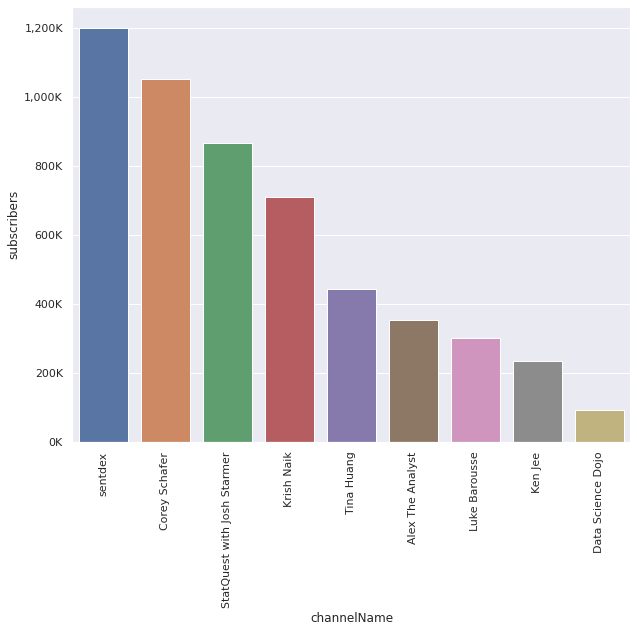

In [9]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

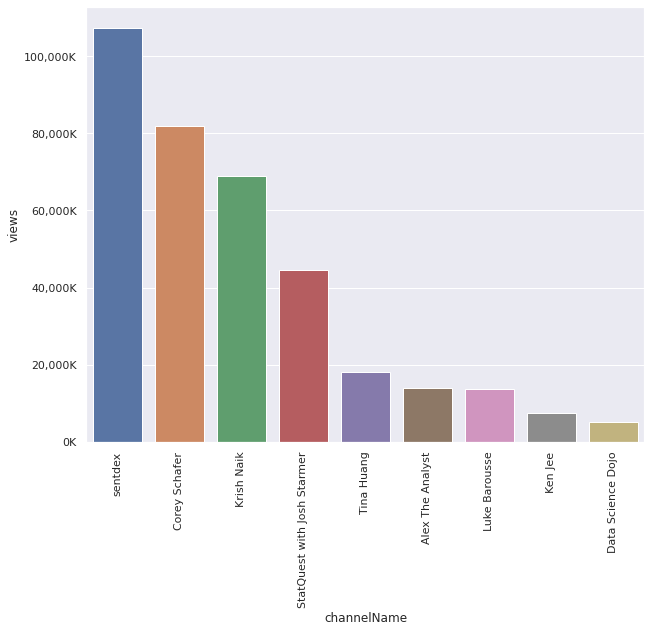

In [10]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [11]:

video_d = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    video_data = get_video_details(youtube, video_ids)
    comments_data = get_comments_in_videos(youtube, video_ids)

    video_d = video_d.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: Tina Huang
Getting video information from channel: Corey Schafer


Could not get comments for video ZB7c00QgmdQ
Getting video information from channel: Data Science Dojo


Could not get comments for video cTeFaUspZwg


Could not get comments for video eghp7pBuV3E


Could not get comments for video ceTSkDWzlE8
Could not get comments for video Ams4sEn50cw


Could not get comments for video 1v-Ca9iyo0k
Could not get comments for video Rcv1O-tv1n8


Could not get comments for video 2FxWwK0djdk
Could not get comments for video RB-OLdJSTh0
Could not get comments for video VlFFkXvzypQ
Getting video information from channel: Luke Barousse
Getting video information from channel: Alex The Analyst
Getting video information from channel: Ken Jee
Getting video information from channel: sentdex


Could not get comments for video XfzbZm89z3o
Getting video information from channel: Krish Naik


Could not get comments for video sjq1OhMzSSU
Getting video information from channel: StatQuest with Josh Starmer


Could not get comments for video BgxBEKhaqyQ


In [12]:
comments_df

,video_id,comments
0,w8opECLgYQU,[The first 500 visitors to https://www.shortfo...
1,I-4xBROt2Zc,[Visit https://365datascience.pxf.io/WD0za3 to...
2,uzCTHdm0T_Q,[Start building your ideal daily routine! The ...
3,pwLaS7nPRxo,[Keep exploring at http://www.brilliant.org/Ti...
4,tmXcKiVwJWg,[Keep exploring at http://www.brilliant.org/Ti...
...,...,...
4282,XNgt7F6FqDU,[Support StatQuest by buying my book The StatQ...
4283,fglJIFv08hs,[Support StatQuest by buying The StatQuest Ill...
4284,2AQKmw14mHM,"[NOTE: When I first made this video, I was thi..."
4285,Sn-keVh_ERw,[Support StatQuest by buying The StatQuest Ill...


In [15]:
video_df = video_d

In [16]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,w8opECLgYQU,Tina Huang,"64 self-help books, summarized in 1 sentence e...",The first 500 visitors to https://www.shortfor...,None,2023-01-10T16:00:34Z,17598,1182,None,119,PT31M56S,hd,false
1,I-4xBROt2Zc,Tina Huang,How to Completely Transform Your Life in 6 Mon...,Visit https://365datascience.pxf.io/WD0za3 to ...,None,2023-01-01T16:00:09Z,183792,12968,None,241,PT12M28S,hd,false
2,uzCTHdm0T_Q,Tina Huang,Self Study Traps to Avoid in 2023 (stop self-s...,Start building your ideal daily routine! The f...,None,2022-12-31T15:00:42Z,49683,3836,None,132,PT12M45S,hd,false
3,pwLaS7nPRxo,Tina Huang,Power From Adversity: how to harness negative ...,Keep exploring at http://www.brilliant.org/Tin...,None,2022-12-29T21:00:58Z,18221,1253,None,93,PT12M25S,hd,false
4,tmXcKiVwJWg,Tina Huang,Tech Layoffs: important lessons to recession p...,Keep exploring at http://www.brilliant.org/Tin...,None,2022-11-27T14:40:42Z,98644,4641,None,366,PT11M26S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,XNgt7F6FqDU,StatQuest with Josh Starmer,"The standard error, Clearly Explained!!!",This StatQuest explains what the standard erro...,"[Standard Error, bootstrapping, statquest, Sta...",2015-05-12T14:10:24Z,165508,3506,None,203,PT11M44S,sd,true
4296,fglJIFv08hs,StatQuest with Josh Starmer,Wrapping up dumplings for pot stickers.,Here's how to wrap up a dumpling that can be m...,"[Dumpling (Type Of Dish), pot stickers, Chines...",2015-04-19T21:18:04Z,7749,91,None,19,PT22S,hd,false
4297,2AQKmw14mHM,StatQuest with Josh Starmer,"R-squared, Clearly Explained!!!",R-squared is one of the most useful metrics in...,"[Coefficient Of Determination, r squared]",2015-02-03T14:48:20Z,499470,10927,None,666,PT11M1S,sd,true
4298,Sn-keVh_ERw,StatQuest with Josh Starmer,onion-dice,"This is how I dice an onion, letting the layer...",[iMovie],2014-09-28T16:12:29Z,8735,109,None,24,PT36S,hd,false


In [17]:
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')


#Preprocessing

In [18]:
video_df.isnull().any()


video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [19]:
video_df.publishedAt.sort_values().value_counts()


2013-06-28T02:54:45Z    11
2014-07-30T02:52:13Z    10
2019-07-03T05:15:02Z     6
2013-06-28T02:54:44Z     5
2016-05-03T23:06:55Z     5
                        ..
2018-07-07T13:41:55Z     1
2018-07-08T12:38:12Z     1
2018-07-09T18:48:49Z     1
2018-07-10T16:39:52Z     1
2023-01-24T14:14:20Z     1
Name: publishedAt, Length: 4242, dtype: int64

In [23]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#Feature engineering

In [24]:
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [25]:
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [26]:
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [27]:
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [28]:
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [29]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,w8opECLgYQU,Tina Huang,"64 self-help books, summarized in 1 sentence e...",The first 500 visitors to https://www.shortfor...,None,2023-01-10 16:00:34+00:00,17598.0,1182.0,NaN,119.0,PT31M56S,hd,false,Tuesday,1916.0,0,67.166723,6.762132,50
1,I-4xBROt2Zc,Tina Huang,How to Completely Transform Your Life in 6 Mon...,Visit https://365datascience.pxf.io/WD0za3 to ...,None,2023-01-01 16:00:09+00:00,183792.0,12968.0,NaN,241.0,PT12M28S,hd,false,Sunday,748.0,0,70.558022,1.311265,74
2,uzCTHdm0T_Q,Tina Huang,Self Study Traps to Avoid in 2023 (stop self-s...,Start building your ideal daily routine! The f...,None,2022-12-31 15:00:42+00:00,49683.0,3836.0,NaN,132.0,PT12M45S,hd,false,Saturday,765.0,0,77.209508,2.656844,57
3,pwLaS7nPRxo,Tina Huang,Power From Adversity: how to harness negative ...,Keep exploring at http://www.brilliant.org/Tin...,None,2022-12-29 21:00:58+00:00,18221.0,1253.0,NaN,93.0,PT12M25S,hd,false,Thursday,745.0,0,68.766808,5.104001,86
4,tmXcKiVwJWg,Tina Huang,Tech Layoffs: important lessons to recession p...,Keep exploring at http://www.brilliant.org/Tin...,None,2022-11-27 14:40:42+00:00,98644.0,4641.0,NaN,366.0,PT11M26S,hd,false,Sunday,686.0,0,47.047970,3.710312,59


#Exploratory analysis

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


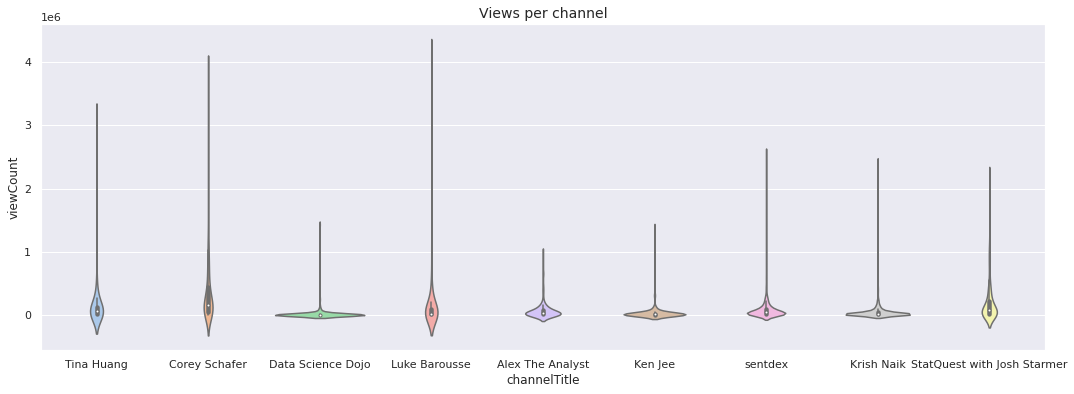

In [30]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

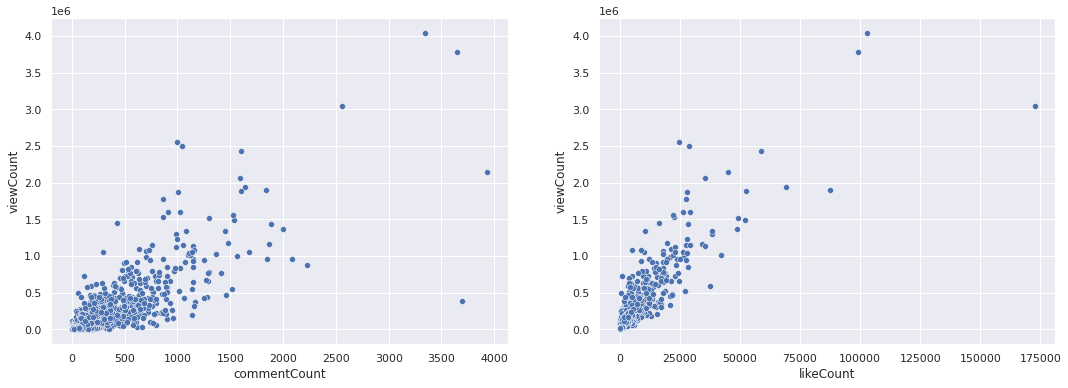

In [31]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

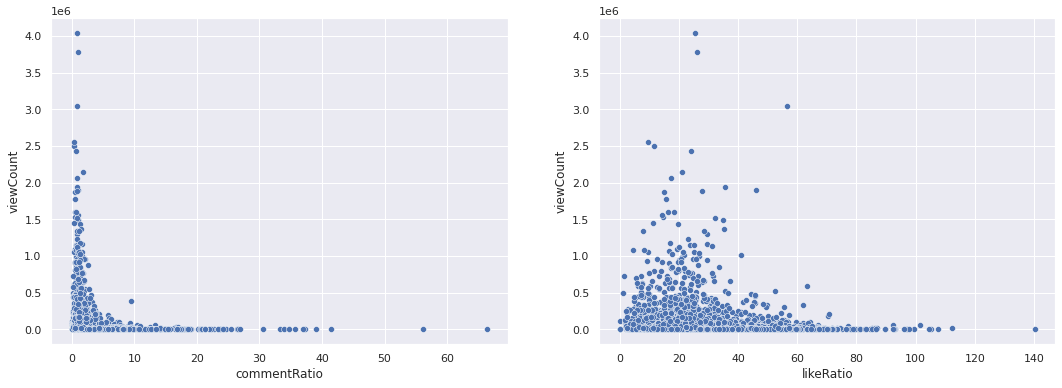

In [32]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

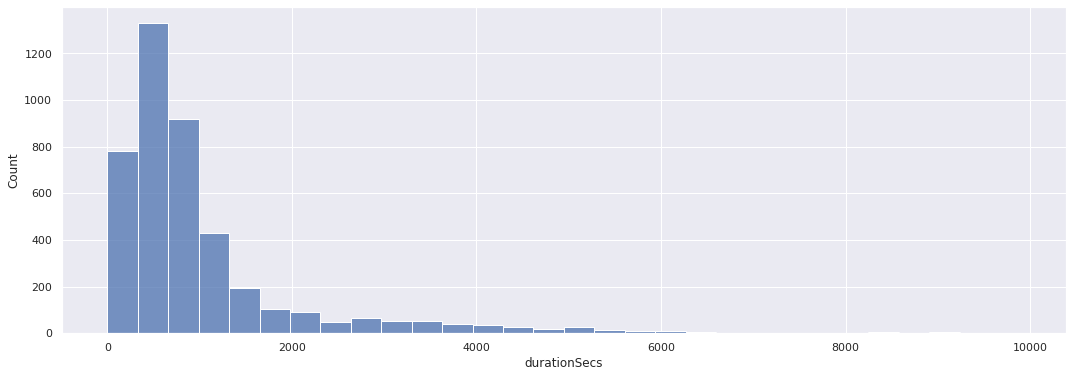

In [33]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)


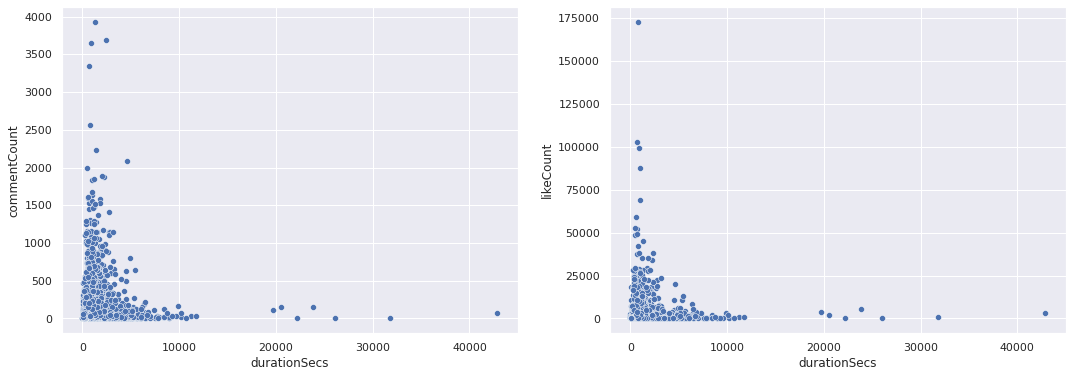

In [34]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

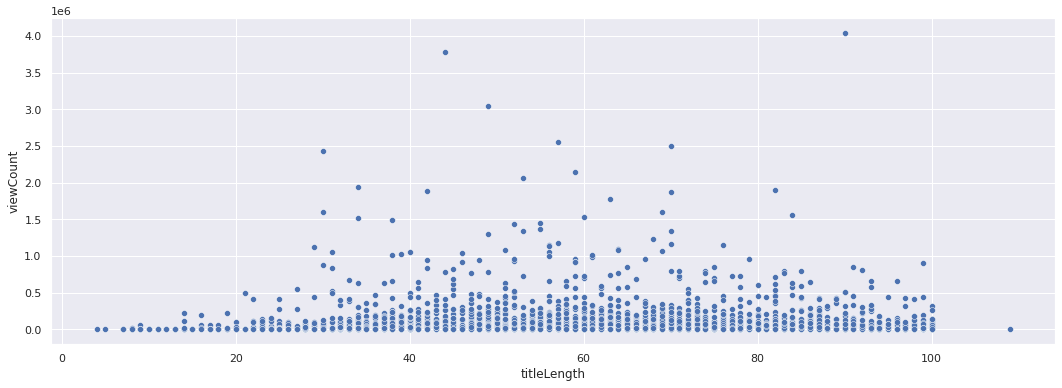

In [35]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

In [36]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

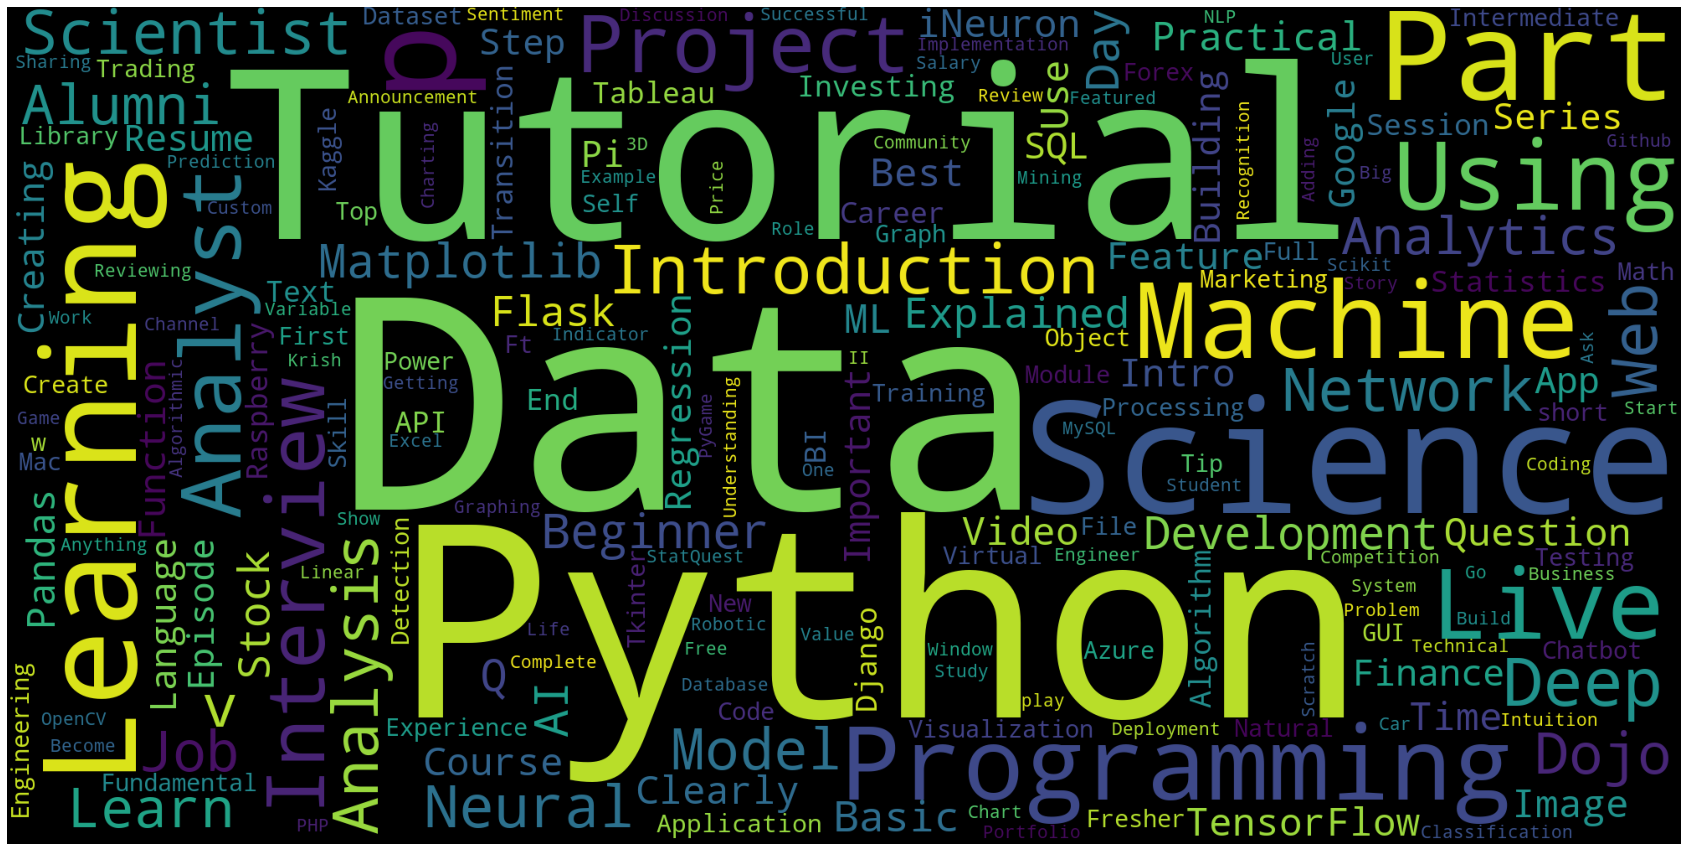

In [37]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

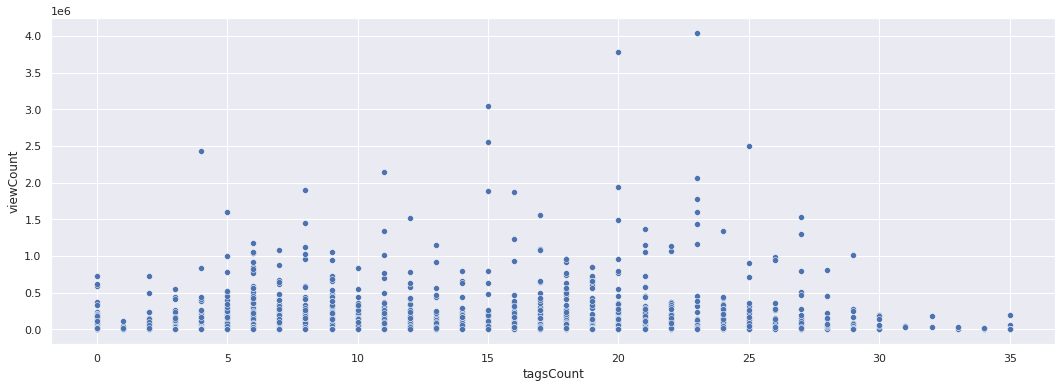

In [38]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")


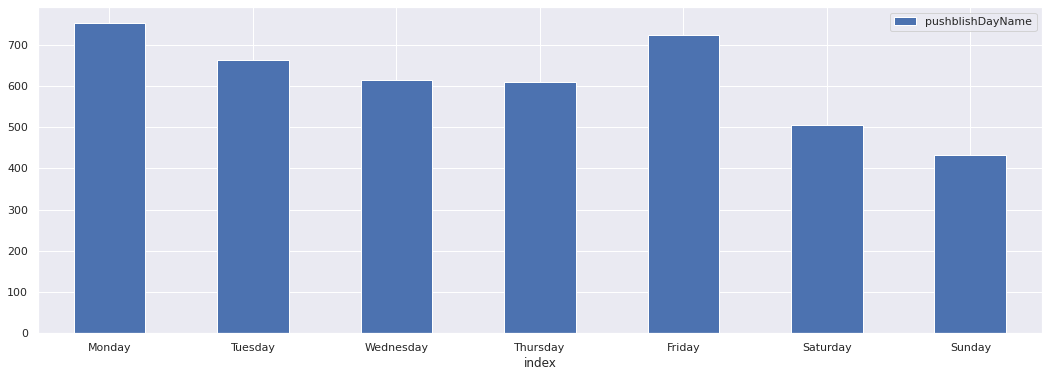

In [39]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

In [40]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

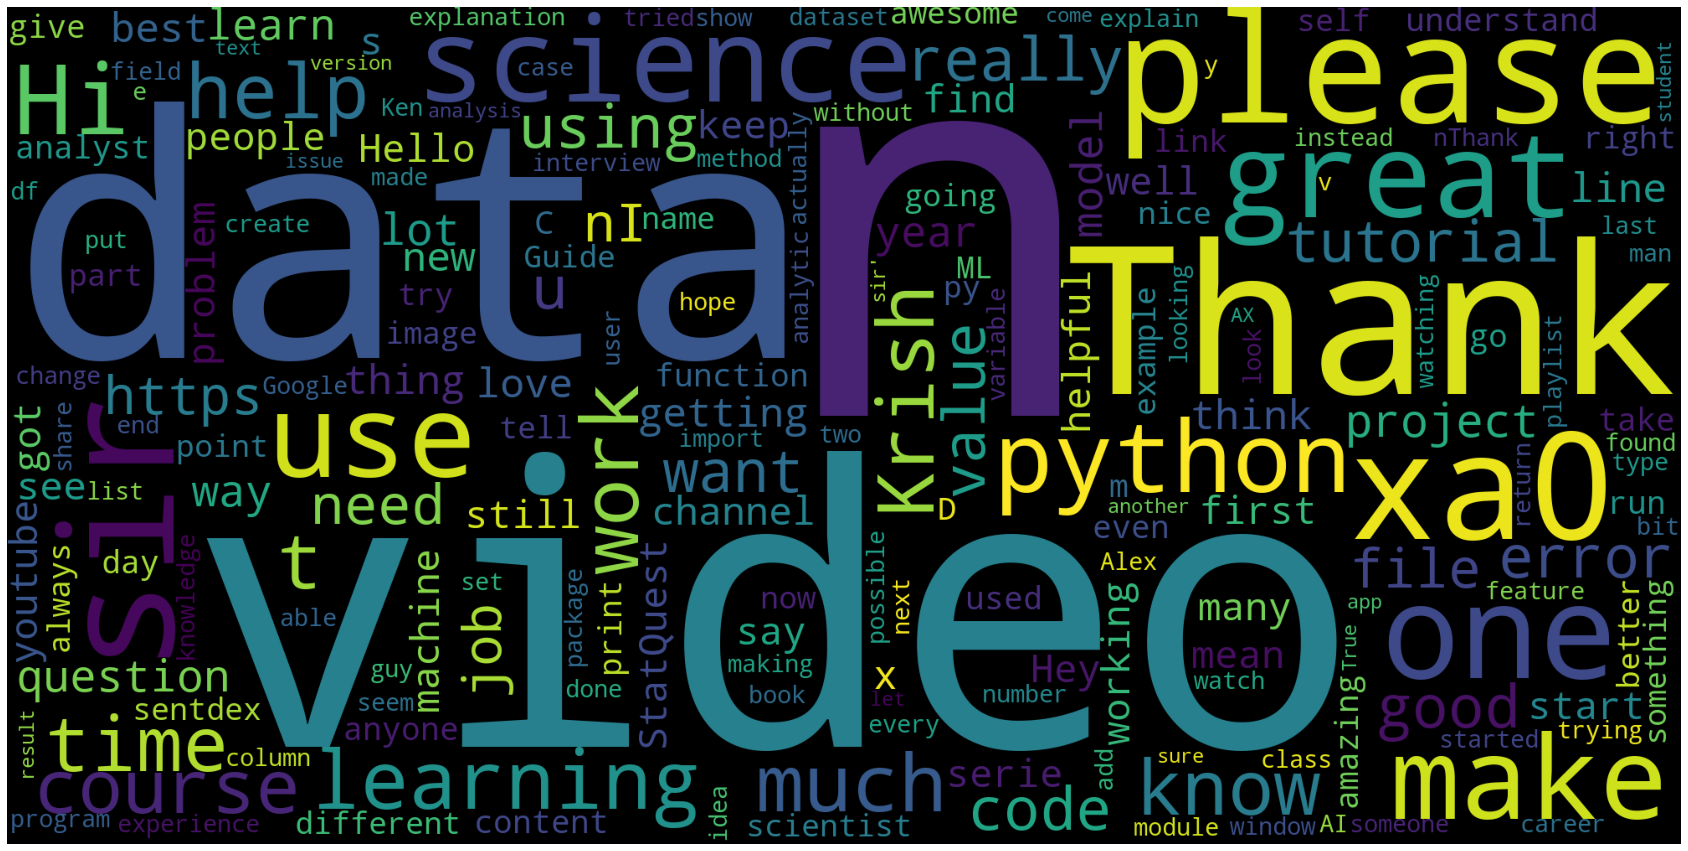

In [41]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#References



1.   Youtube API. Avaiable at https://developers.google.com/youtube/v3
2.   Guide: https://www.youtube.com/@Thuvu5

